# Networks and Laplacian Spectrum: a case study on the Arawakan linguistic family 

## (1) Lenguas de la Américas
### Extraemos las lenguas de América del Sur y de América del Norte desde los datos de Glottolog
### https://glottolog.org/meta/downloads

In [1]:
## usamos pandas para leer .csv

import pandas as pd 

In [2]:
## clasificación por macroárea 

macroarea = pd.read_csv('languages_and_dialects_geo.csv',sep=',')

In [3]:
## borramos donde no hay datos (NaN)

macroarea.dropna(inplace = True)

In [4]:
## nos quedamos con un dataframe con dos columnas: iso vs macroárea

macroarea = macroarea[['isocodes','macroarea']]

In [5]:
## transformamos los datos en un diccionario iso:macroarea
## filtramos por macroarea 'South America' y 'North America'

macroarea = dict(zip(macroarea['isocodes'], macroarea['macroarea']))
macroarea = {language:macroarea[language] for language in macroarea.keys() if macroarea[language] in ['South America','North America']}

In [6]:
## ¿cuántas lenguas tenemos?

print('número de lenguas: '+str(len(macroarea.keys())))

número de lenguas: 1208


In [7]:
## de este conjunto de 1208 lenguas, filtramos las que están en el corpus UDHR
## https://www.unicode.org/udhr/index.html

languages={}

for language in macroarea.keys():
    #with open('udhr_' + language + '.txt', 'r', encoding='utf-8') as file:
    try: 
        file = open('udhr/'+'udhr_'+language+'.txt', 'r')  
        language_text=file.read().split('\n')
        languages[language]=[line.strip() for line in language_text]
        languages[language]=[line for line in languages[language] if len(line)>0]
    except FileNotFoundError:
        pass

In [8]:
## nuevo número de lenguas :)

print(len(languages))

85


In [9]:
## mapudungun :)
## solo imprimimos los primeros 10 elementos de la lista

languages['arn'][:10]

['Universal Declaration of Human Rights - Mapudungun',
 '© 1996 – 2009 The Office of the High Commissioner for Human Rights',
 'This plain text version prepared by the “UDHR in Unicode”',
 'project, https://www.unicode.org/udhr.',
 '---',
 'Kom Mapu Fijke Az Tañi Az Mogeleam',
 'Tuwvlzugun',
 '("Preámbulo" pi ta wigka)',
 'Kimnieel fij mapu mew tañi kimgen kvme felen kisugvnew felen xvr kvme mvlen. Tvfaci zugu ñi mvleken mvleyem yamvwvn ka xvr kvme nor felen kom pu reñmawke ce mew.',
 'Gewenonmu yamuwvn, zuamgewenonmu kvme felen, goymagenmu nor felen mvley re jazkvnkawvn: Fey mew mvley xvrvmzugu kom pu ce tañi kvme mogeleam kisuke ñi feyentun mew, kisu ñi rakizuam mew ka ñi wimtun mew ñi mvleal egvn.']

### Descripción del corpus

In [10]:
## dos funciones que permiten "limpiar" los datos con el fin de construir redes.
## la primera tokeniza strings. Usamos como definición de palabra como la cadena de caracteres entre dos espacios en blanco. 
## la segunda (i) elimina símbolos raros, elimina espacios vacíos, elimina números y remueve los encabezados

def tokenize(s):
    return s.split(' ')

def clean(L):
    language=languages[L]
    table = str.maketrans({key: None for key in '``!"#$%&\¿()*+,-./:;<=>?@[\\]_{|}'})
    language=[list(filter(None, [w.lower().translate(table) for w in tokenize(sentence)])) for sentence in language if len([w.lower() for w in [w.translate(table) for w in tokenize(sentence)]])>0]
    language=[[w for w in s if w!="''"] for s in language] 
    language=[[w for w in s if w!='̃'] for s in language] 
    language=[[w for w in s if not w.isdigit()] for s in language]
    if L=='zro':
        return language[6:]
    elif L=='tca':
        return language[7:]
    elif L=='gyr':
        return language[9:]
    else:
        return language[5:]

In [11]:
## aplicamos las funciones anteriores.

clean_languages={}
for language in languages:
    clean_languages[language]=clean(language)

In [12]:
## para cada ejemplo, mostramos cómo queda la primera oración. 

for language in clean_languages.keys():
    print(language, clean_languages[language][0])

acu ['kintati', 'diciembre', 'nantuti', 'musachtin', 'apu', 'ainau', 'iruntrar', 'tu', 'aarmi', 'tusar', 'nunia', 'aarar', 'mash', 'nungkanam', 'pujuinau', 'angkan', 'pengker', 'pujusarti', 'tusar', 'aararmiayi']
agr ['ashi', 'aents', 'yakat', 'muun', 'aidaunmaya', 'ijunjamunum', 'tsawan', 'de', 'diciembre', 'tin', 'etsejau', 'ainawai', 'juju', 'ashi', 'aents', 'aidaunum', 'uminkatin', 'ati', 'tusa', 'nunu', 'tsawantai', 'jintiajajui', 'chichaman', 'dutika', 'ashi', 'nugkanum', 'iwainaju', 'ainawai', 'aents', 'nii', 'anentaibau', 'nii', 'wakejamu', 'yupichu', 'dutikashmin', 'chichajamunum', 'ayamkagtaun', 'tuja', 'tiaju', 'ainawai', 'juju', 'chicham', 'pegkeg', 'jintiagmawa', 'juka', 'juwig', 'nagkankashti', 'ashi', 'nugkanum', 'dapampaejati', 'yakat', 'muun', 'aidaunum', 'yakat', 'piipich', 'aidaunmashkam', 'papi', 'aujtainmash', 'ashi', 'tutinjati', 'tiajui', 'tuja', 'papinum', 'agajag', 'sujuktinme', 'tiajui', 'ashi', 'aents', 'aidau', 'aujus', 'dekatnume', 'tusa', 'makichkish', 'ug

In [13]:
## contamos palabras 

from collections import Counter

words_entropy={}
words={}
mean_tokens={}
mean_types={}
for language in clean_languages.keys():
    words_entropy[language]=[item for sublist in clean_languages[language] for item in sublist]
    words[language]=[len([item for sublist in clean_languages[language] for item in sublist]),len(set([item for sublist in clean_languages[language] for item in sublist])),Counter([item for sublist in clean_languages[language] for item in sublist])]
    mean_tokens[language]=len([item for sublist in clean_languages[language] for item in sublist])
    mean_types[language]=len(set([item for sublist in clean_languages[language] for item in sublist]))
    print(language,len(clean_languages[language]),len([item for sublist in clean_languages[language] for item in sublist]),len(set([item for sublist in clean_languages[language] for item in sublist])))

acu 92 1676 559
agr 90 1811 827
amc 87 1496 672
amr 93 1407 421
qva 92 1715 762
arl 94 1973 530
qxu 94 1124 542
cni 92 1305 515
prq 75 626 258
kwi 202 1294 733
quy 93 1279 645
qug 239 1409 702
boa 96 1567 704
qvc 90 1153 599
qud 91 933 456
cbu 91 1290 574
cot 94 1532 715
hns 94 2221 490
cbr 92 2204 542
cbs 76 626 258
ayr 91 925 610
maz 91 1544 310
cbi 100 3120 959
cic 93 554 301
csa 96 1699 425
qxa 90 1477 738
zam 95 1409 227
quz 94 1128 664
ike 70 857 620
ese 68 763 529
cab 94 1330 476
gyr 78 1159 459
ztu 92 1342 326
qvh 90 1934 850
hus 94 1554 335
qwh 91 1326 606
mzi 99 1250 570
kal 91 1039 682
cak 90 2514 454
kek 91 1520 407
quc 90 2171 501
mam 91 1527 440
arn 91 1712 390
qvm 92 1373 642
mcf 95 2373 600
mxv 94 1336 396
ote 91 1819 317
mic 91 1330 573
miq 85 1634 394
huu 91 1294 385
nav 91 1601 779
not 91 1100 383
qxn 89 1604 668
qvn 90 1346 680
ojb 93 1126 587
chj 91 1683 423
pbb 90 1467 700
top 92 1554 571
pap 90 1878 480
gug 83 1154 576
cpu 92 2352 862
ppl 91 1856 354
tsz 91 1279 

## (2) Laplacian Spectrum
### Usamos redes para extraer rasgos de lenguas de las Américas. Nuestros rasgos son los valores propios de la matriz de adyacencia de los grafos (en principio)
### https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors

In [14]:
## famosa librería de redes
import networkx as nx

In [15]:
## grafos: para cada texto, recorremos sus oraciones y en cada una buscamos pares de palabras adyacentes

def GoW(text_clean,radius=1):
    ## partimos con un grafo vacío (sin nodos o aristas)
    G=nx.Graph()
    ## recorremos las oraciones
    for sentence in text_clean:
        ## si tiene al menos dos palabras
        if len(sentence)>1:
            ## en "pairs" guardamos momentáneamente los pares de palabras adyacentes
            pairs=[]
            ## usamos un radio, que fijamos inicialmente en 1
            for r in list(range(1,radius+1)):
                ## usamos zip para crear bigramas
                pairs+=list(zip(sentence,sentence[r:]))#+list(zip(sentence,sentence[2:]))+list(zip(sentence,sentence[3:]))
            for pair in pairs:
                ## si una arista no está la agregamos
                if G.has_edge(pair[0],pair[1])==False:
                    G.add_edge(pair[0],pair[1],weight=1)
                #else:
                #    x=G[pair[0]][pair[1]]['weight']
                #    G[pair[0]][pair[1]]['weight']=x+1
    
    return G

In [16]:
## calculamos los grafos

graphs={}
for language in languages.keys():
    #print(language)
    G=GoW(clean_languages[language])
    graphs[language]=G

In [17]:
len(graphs)

85

In [18]:
## ahora extraemos los valores propios
## usamos la matriz laplaciana normalizada
## https://en.wikipedia.org/wiki/Laplacian_matrix
from numpy import linalg as LA
import numpy as np

def spectrum(G):
    M=nx.normalized_laplacian_matrix(G).todense()
    eigs=LA.eigvals(M)
    return eigs

In [19]:
## guardamos el espectro usando la función anterior

spectrum_languages={}

for language in graphs.keys():
    #print(language)
    G=graphs[language]
    spectrum_languages[language]=sorted([np.real(n) for n in spectrum(G)])

## (3) Familias lingüísticas
### Extraemos de Glottolog la información de las familias lingüísticas de las Américas. Para acceder automáticamente a esa información, usamos la librería lang2vec https://github.com/antonisa/lang2vec

In [20]:
## instalación de lang2vec con pip

!pip3 install lang2vec

    100% |████████████████████████████████| 10.2MB 4.9MB/s eta 0:00:01
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [21]:
## llamamos la librería

import lang2vec.lang2vec as l2v

In [22]:
## familias según Glottolog
## esta parte se demora un poco, asi que guardamos los datos en la celda siguiente

#families=l2v.get_features('arn', "fam",header=True)['CODE']

#families_languages={language:[] for language in languages.keys()}

#for language in languages.keys():
#    fam = l2v.get_features(language, "fam")
#    if 1 in fam[language]:
#        indexes = np.where(np.array(fam[language]) == 1)[0]
#        for ii in indexes:
#            families_languages[language]+=[families[ii]]

In [23]:
## guardamos usando pickle

#import pickle

#pickle.dump(families_languages,open('families_languages.p','wb'))

In [24]:
import pickle

families_languages = pickle.load(open('families_languages.p','rb'))

In [25]:
## familias lingüísticas

family = {key:families_languages[key][0][2:] for key in families_languages.keys() if len(families_languages[key])>0}

In [26]:
family

{'acu': 'Jivaroan',
 'agr': 'Jivaroan',
 'amc': 'Panoan',
 'amr': 'Harakmbut',
 'qva': 'Quechuan',
 'arl': 'Zaparoan',
 'qxu': 'Quechuan',
 'cni': 'Arawakan',
 'prq': 'Arawakan',
 'kwi': 'Barbacoan',
 'quy': 'Quechuan',
 'qug': 'Quechuan',
 'boa': 'Boran',
 'qvc': 'Quechuan',
 'qud': 'Quechuan',
 'cot': 'Arawakan',
 'hns': 'Indo-European',
 'cbr': 'Panoan',
 'cbs': 'Panoan',
 'ayr': 'Aymara',
 'maz': 'Otomanguean',
 'cbi': 'Barbacoan',
 'cic': 'Muskogean',
 'csa': 'Otomanguean',
 'qxa': 'Quechuan',
 'zam': 'Otomanguean',
 'quz': 'Quechuan',
 'ike': 'Eskimo-Aleut',
 'ese': 'Tacanan',
 'cab': 'Arawakan',
 'gyr': 'Tupian',
 'ztu': 'Otomanguean',
 'qvh': 'Quechuan',
 'hus': 'Mayan',
 'qwh': 'Quechuan',
 'mzi': 'Otomanguean',
 'kal': 'Eskimo-Aleut',
 'cak': 'Mayan',
 'kek': 'Mayan',
 'quc': 'Mayan',
 'mam': 'Mayan',
 'arn': 'Araucanian',
 'qvm': 'Quechuan',
 'mcf': 'Panoan',
 'mxv': 'Otomanguean',
 'ote': 'Otomanguean',
 'mic': 'Algic',
 'miq': 'Misumalpan',
 'huu': 'Huitotoan',
 'nav': 'At

In [27]:
## agrupamos las lenguas que tienen la misma familia

from collections import defaultdict

v = defaultdict(list)

for key, value in sorted(family.items()):
    v[value].append(key)

In [28]:
v = dict(v)

In [29]:
v

{'Jivaroan': ['acu', 'agr', 'jiv'],
 'Panoan': ['amc', 'cbr', 'cbs', 'mcd', 'mcf', 'shp'],
 'Arawakan': ['ame', 'cab', 'cni', 'cot', 'cpu', 'guc', 'not', 'prq'],
 'Harakmbut': ['amr'],
 'Zaparoan': ['arl', 'zro'],
 'Araucanian': ['arn'],
 'Aymara': ['ayr'],
 'Boran': ['boa'],
 'Mayan': ['cak', 'hus', 'kek', 'mam', 'quc', 'toj', 'tzh', 'yua'],
 'Barbacoan': ['cbi', 'cof', 'kwi'],
 'Cahuapanan': ['cbt'],
 'Otomanguean': ['chj', 'csa', 'maz', 'mxv', 'mzi', 'ote', 'zam', 'ztu'],
 'Muskogean': ['cic'],
 'Algic': ['csw', 'mic', 'ojb'],
 'Tacanan': ['ese'],
 'Tupian': ['gug', 'gyr'],
 'Yanomam': ['guu'],
 'Indo-European': ['hns', 'pap'],
 'Huitotoan': ['huu'],
 'Eskimo-Aleut': ['ike', 'kal'],
 'Misumalpan': ['miq'],
 'Mixe-Zoque': ['mto'],
 'Athapaskan-Eyak-Tlingit': ['nav'],
 'Uto-Aztecan': ['nhn', 'ppl'],
 'Quechuan': ['qud',
  'qug',
  'quy',
  'quz',
  'qva',
  'qvc',
  'qvh',
  'qvm',
  'qvn',
  'qwh',
  'qxa',
  'qxn',
  'qxu'],
 'Tucanoan': ['sey', 'snn'],
 'Ticuna-Yuri': ['tca'],
 'Gu

In [41]:
## librerías para graficar

import matplotlib.pyplot as plt

### Arawak vs todas las lenguas de las Américas
### filtramos por las familias más representadas: Quechua, Pano, Maya, Otomangue

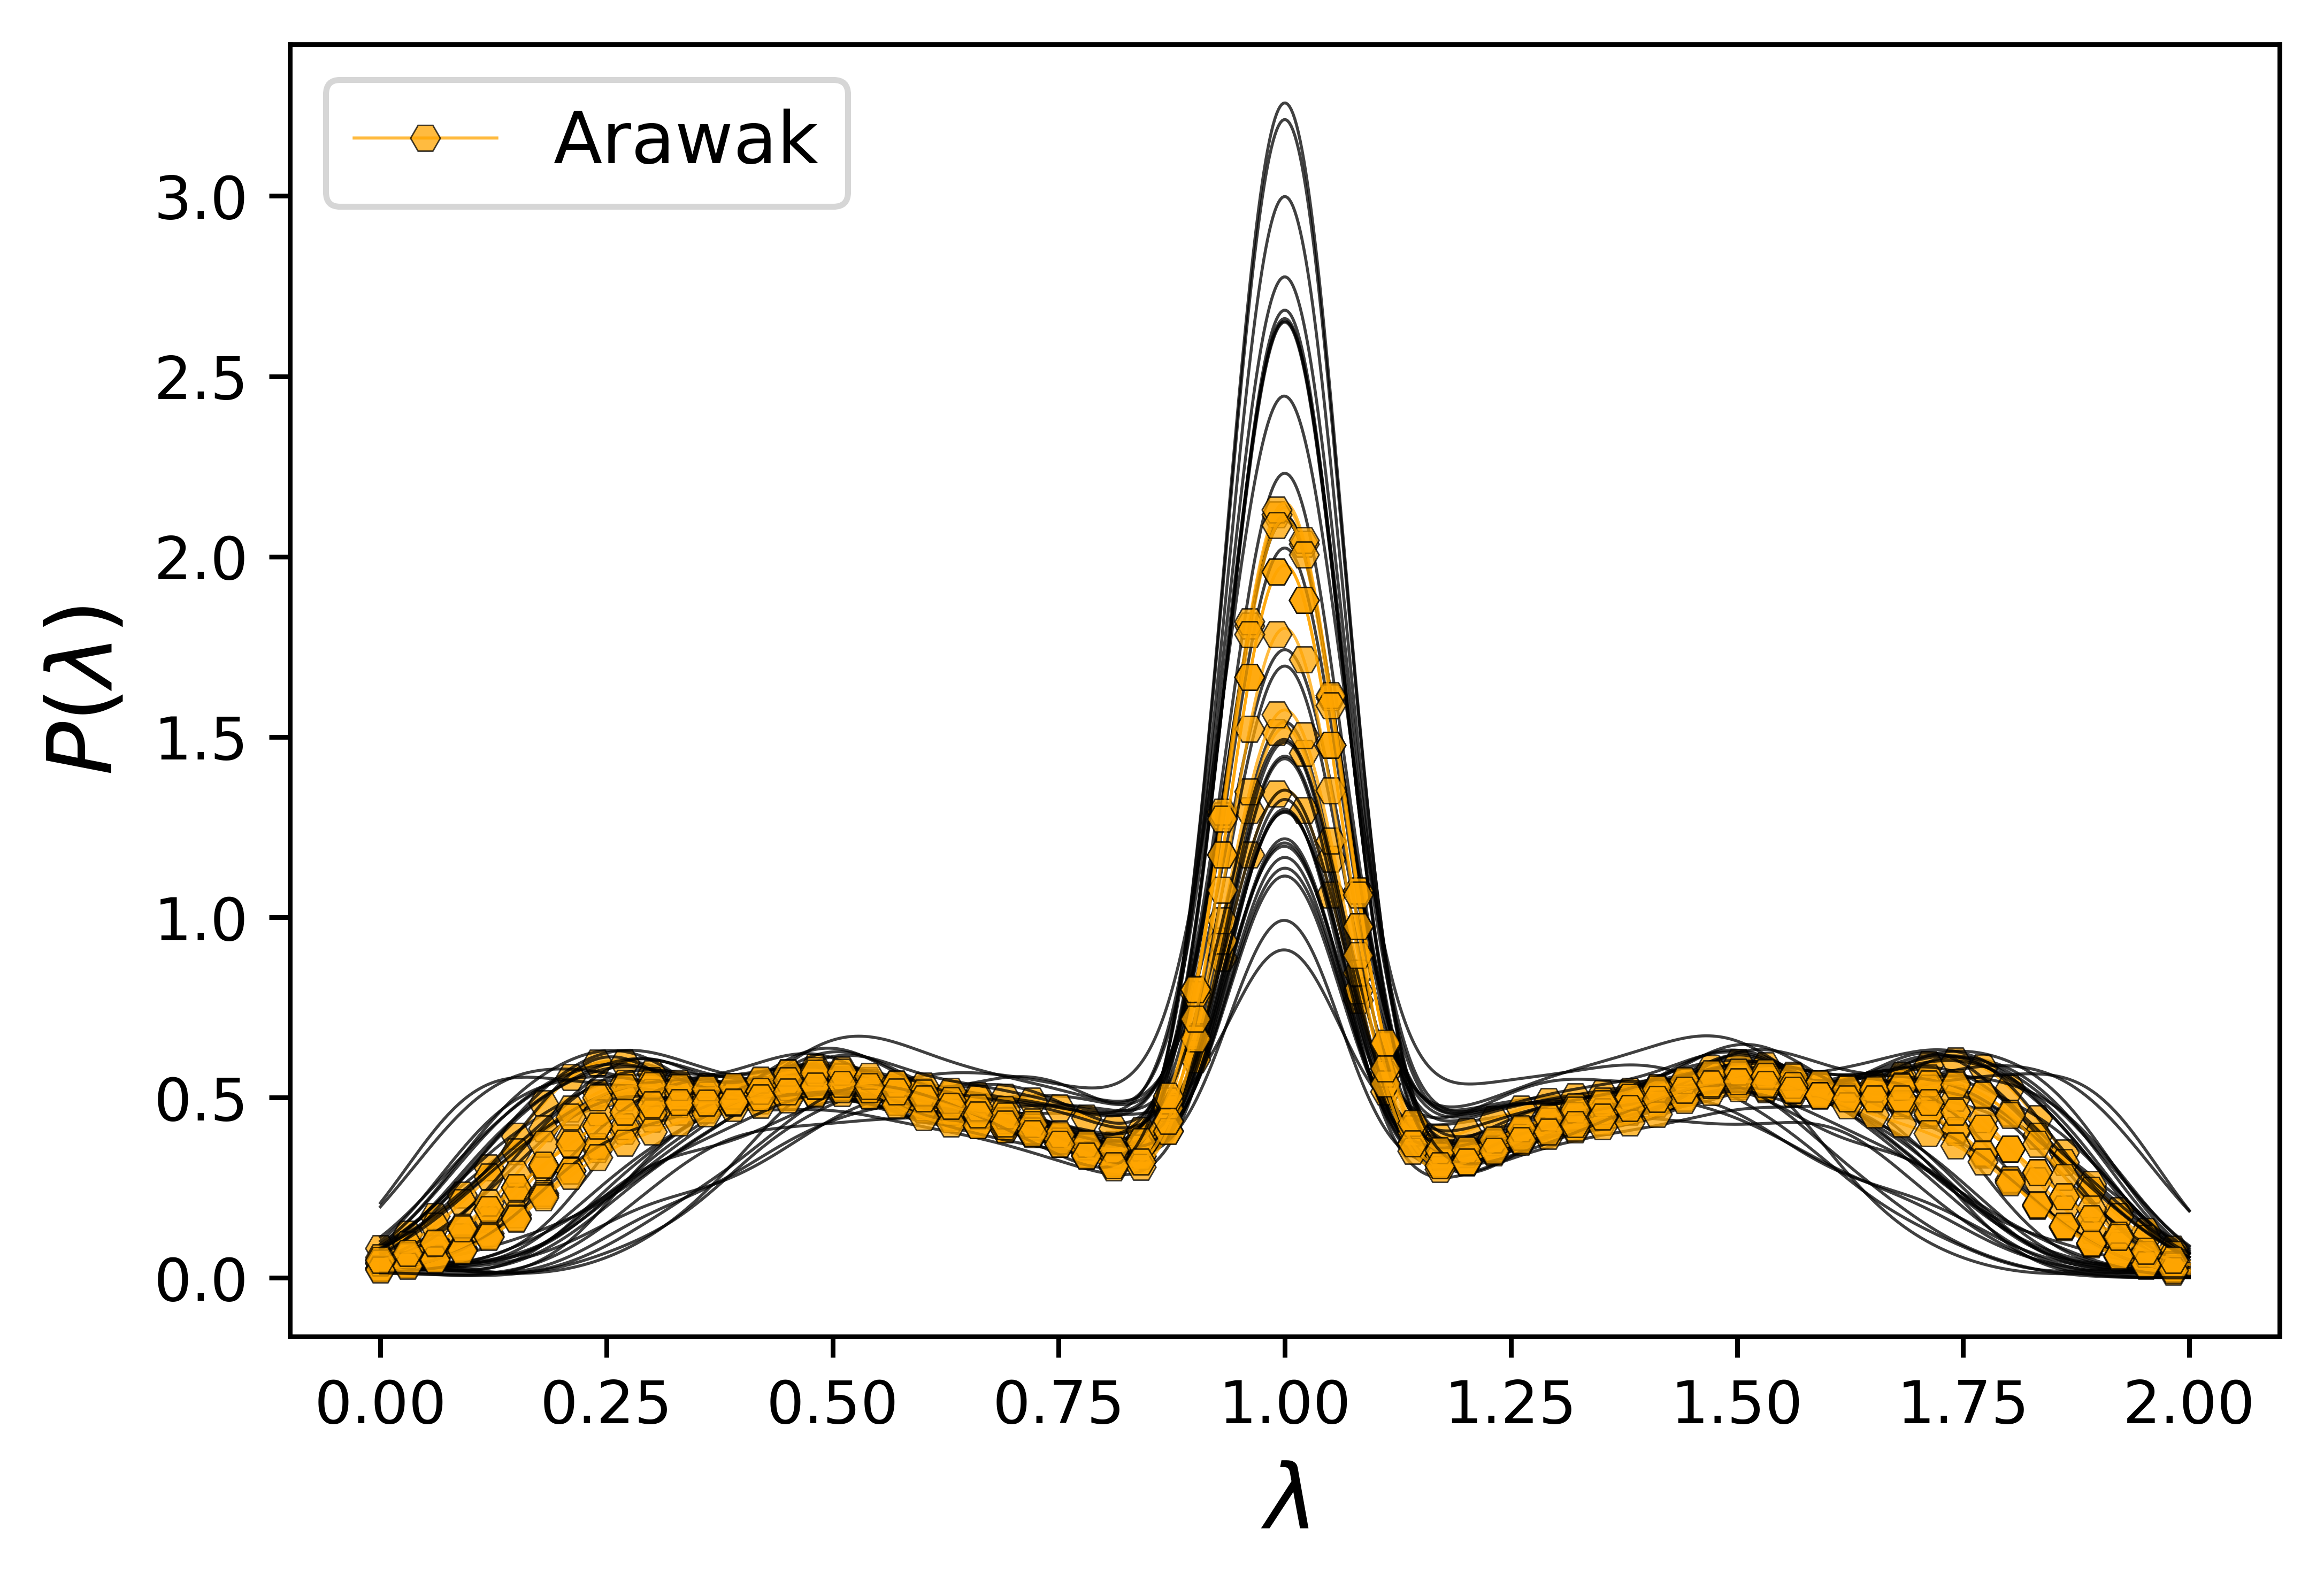

In [78]:
fig, ax = plt.subplots(dpi=800)

import matplotlib.colors
cmap = plt.cm.viridis

A = []

for language in family.keys():
    data = np.array(spectrum_languages[language])
    #plt.hist(data, bins='doane', cumulative=False, alpha=0.1,histtype='step',stacked=False,density=True,
    #    zorder=5, edgecolor='k')
    kde = sm.nonparametric.KDEUnivariate(data)
    kde.fit(bw=0.065) # Estimate the densities
    X=np.linspace(0, 2, num=1000)
    prediction=[kde.evaluate(x) for x in X]
    
    if family[language] in ['Quechuan','Panoan','Mayan','Otomanguean']:
        ax.plot(X, prediction, '-', lw=0.5, color='k', alpha=0.75, zorder=10)
    elif family[language]=='Arawakan':
        A+=[prediction]
        ax.plot(X, prediction, markevery=15,marker='H',markersize=5,markeredgecolor='k',markeredgewidth=0.25,fillstyle='full', lw=0.5, alpha=0.75, color='orange', zorder=10)

ax.plot(X, A[0], markevery=15,marker='H',markersize=5,markeredgecolor='k',markeredgewidth=0.25,fillstyle='full', lw=0.5, alpha=0.75, color='orange', zorder=10, label='Arawak')

plt.legend(loc='upper left',fontsize=12)
#plt.xlim([-10,10])
#plt.ylim([0., 3])
plt.xlabel(r'$\lambda$',fontsize=15)
plt.ylabel(r'$P(\lambda)$',fontsize=15)
plt.rcParams.update({'font.size': 10})
plt.savefig('spectrum_arawak_all.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
plt.show()

### Arawak vs macroareas

In [ ]:
fig, ax = plt.subplots(dpi=800)

import matplotlib.colors
cmap = plt.cm.viridis

A = []
QP = []
MO = []

for language in family.keys():
    data = np.array(spectrum_languages[language])
    #plt.hist(data, bins='doane', cumulative=False, alpha=0.1,histtype='step',stacked=False,density=True,
    #    zorder=5, edgecolor='k')
    kde = sm.nonparametric.KDEUnivariate(data)
    kde.fit(bw=0.065) # Estimate the densities
    X=np.linspace(0, 2, num=1000)
    prediction=[kde.evaluate(x) for x in X]
    
    if family[language] in ['Quechuan','Panoan']:
        QP+=[prediction]
        ax.plot(X, prediction, markevery=20,marker='o',markersize=4,markeredgecolor='k',markeredgewidth=0.25,fillstyle='full', lw=0.5, alpha=0.5, color='b', zorder=10)
    elif family[language] in ['Mayan','Otomanguean']:
        MO+=[prediction]
        ax.plot(X, prediction, markevery=20, marker='X',markersize=4,markeredgecolor='k',markeredgewidth=0.25,fillstyle='full', lw=0.5, alpha=0.5, color='m', zorder=10)
    elif family[language]=='Arawakan':
        A+=[prediction]
        ax.plot(X, prediction, markevery=20,marker='H',markersize=5,markeredgecolor='k',markeredgewidth=0.25,fillstyle='full', lw=0.5, alpha=0.75, color='orange', zorder=10)

ax.plot(X, A[0], markevery=20,marker='H',markersize=5,markeredgecolor='k',markeredgewidth=0.25,fillstyle='full', lw=0.5, alpha=0.75, color='orange', zorder=10, label='Arawak')
ax.plot(X, QP[0],markevery=20,marker='o',markersize=4,markeredgecolor='k',markeredgewidth=0.25,fillstyle='full', lw=0.5, alpha=0.5, color='b', zorder=10, label='Quechua+Pano')
ax.plot(X, MO[0],markevery=20,marker='X',markersize=4,markeredgecolor='k',markeredgewidth=0.25,fillstyle='full', lw=0.5, alpha=0.5, color='m', zorder=10, label='Maya+Otomangue')

plt.legend(loc='upper left',fontsize=12)
#plt.xlim([-10,10])
#plt.ylim([0., 3])
plt.xlabel(r'$\lambda$',fontsize=15)
plt.ylabel(r'$P(\lambda)$',fontsize=15)
plt.rcParams.update({'font.size': 10})
plt.savefig('spectrum_arawak_macro.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
plt.show()